In [ ]:
knitr::opts_chunk$set(echo = TRUE, eval = TRUE, cache=FALSE, tidy = "styler", dev = "png")

In [3]:
source(here::here("scripts/init.R"))

Loading methylayer


Attaching package: ‘testthat’


The following object is masked from ‘package:dplyr’:

    matches


The following object is masked from ‘package:purrr’:

    is_null


The following object is masked from ‘package:tidyr’:

    matches




# Import and load TCGA breast cancer methylation and expression data

We use the following biocnductor packages to load TCGA-BRCA data:

- [curatedTCGAData](https://github.com/waldronlab/curatedTCGAData)
- [TCGAutils](https://github.com/waldronlab/TCGAutils)

We take the __BRCA_Methylation_methyl450-20160128__ dataset for 450k array methylaton data and __BRCA_RNASeq2GeneNorm-20160128__ for expression data. Methylation data is saved as `misha` `track.array`. 

Import is done by running:

```r
import_breast_tcga()
```

See `scripts/tcga/import.r` at [tanaylab/metabric_rrbs](https://github.com/tanaylab/metabric_rrbs) for details. 

Loading is done by running the following commands: 

In [4]:
init_tcga_samp_data()
head(tcga_samp_data)

samp_id        barcode                      submitter_id sample_definition  
1 TCGA_3C_AAAU_T TCGA-3C-AAAU-01A-11D-A41Q-05 TCGA-3C-AAAU Primary Solid Tumor
2 TCGA_3C_AALI_T TCGA-3C-AALI-01A-11D-A41Q-05 TCGA-3C-AALI Primary Solid Tumor
3 TCGA_3C_AALJ_T TCGA-3C-AALJ-01A-31D-A41Q-05 TCGA-3C-AALJ Primary Solid Tumor
4 TCGA_3C_AALK_T TCGA-3C-AALK-01A-11D-A41Q-05 TCGA-3C-AALK Primary Solid Tumor
5 TCGA_4H_AAAK_T TCGA-4H-AAAK-01A-12D-A41Q-05 TCGA-4H-AAAK Primary Solid Tumor
6 TCGA_5L_AAT0_T TCGA-5L-AAT0-01A-12D-A41Q-05 TCGA-5L-AAT0 Primary Solid Tumor
  sample vial portion analyte plate center type ER HER2 PR gender PAM50 age
1 1      A    11      D       A41Q  5      T                            NA 
2 1      A    11      D       A41Q  5      T                            NA 
3 1      A    31      D       A41Q  5      T                            NA 
4 1      A    11      D       A41Q  5      T                            NA 
5 1      A    12      D       A41Q  5      T                            NA 
6 1      A    12      D       A41Q  5      T                            NA 
  stage IHC patient     
1           TCGA_3C_AAAU
2           TCGA_3C_AALI
3           TCGA_3C_AALJ
4           TCGA_3C_AALK
5           TCGA_4H_AAAK
6           TCGA_5L_AAT0

Load TCGA-BRCA expression and methylation data. Methylation data is sperated to promoters and non-promoters.

In [5]:
load_all_tcga_brca_data()

Expression data:

In [6]:
dim(tcga_expr)
dim(tcga_expr_positive)
dim(tcga_expr_negative)
dim(tcga_expr_normal)

[1] 20501  1212

[1] 20501   594

[1] 20501   179

[1] 20501    89

Promoter methylation data:

In [7]:
dim(tcga_prom_meth)
dim(tcga_prom_meth_positive)
dim(tcga_prom_meth_negative)
dim(tcga_prom_meth_normal)

[1] 32378   885

[1] 32378   358

[1] 32378   111

[1] 32378    82

Non-promoter methylation data:

In [8]:
dim(tcga_genomic_meth)
dim(tcga_genomic_meth_positive)
dim(tcga_genomic_meth_negative)
dim(tcga_genomic_meth_normal)

[1] 176342    885

[1] 176342    358

[1] 176342    111

[1] 176342     82

Combined promoters and non-promoter methylation:

> Note: The full matrix for TCGA-BRCA methylation has a row per **CpG** whereas for normalization we averaged the CpGs of every promoter.

In [9]:
dim(all_meth)
dim(all_meth_positive)
dim(all_meth_negative)
dim(all_meth_normal)

[1] 394182    886

[1] 394182    358

[1] 394182    111

[1] 394182     82

# Normalize tumor microenvironment (TME) effects

Sampling DNA methylation from bulk tumor tissue is known to be affected by variable populations of stromal and immune cells. Mean methylation levels per samples and locus can thereby represent mixtures of distinct epigenomic signatures from different cell types. 

To facilitate robust deconvolution of these tumor microenvironment (TME) effects, _methylayer_ uses an unsupervised approach relying on analysis of the cross-correlations between gene expression profiles with promoter methylation signatures. 

In broad strokes, _methylayer_'s normalization strategy is to:

- Compute cross-correlation between gene expression and promoter methylation. 
- Cluster the cross correlation matrix to identify TME expression signatures (i.e. groups of TME genes that affect promoter methylation).
- Use the Euclidean distance in the 2D space of these signatures to identify the K-nearest neighbors of each tumor.
- Substract from the raw methylation value of each tumor the mean methylation of its K neighbors.

It should be noted that using smaller K values will increase noise (since the neighborhood mean methylation will becomes less stable), while using larger K values may lead to less effective normalization of the TME signatures. 

See `?deconv_TME` for more details.

## Normalize ER+/ER-/normal TCGA-BRCA samples

In [10]:
ER_positive_norm_meth <- deconv_TME(tcga_prom_meth_positive, tcga_expr_positive, all_meth_positive, k = 15) %cache_rds% here("data/TCGA-BRCA/TCGA_BRCA_ER_positive_norm_meth.rds")

In [11]:
ER_negative_norm_meth <- deconv_TME(tcga_prom_meth_negative, tcga_expr_negative, all_meth_negative, k = 15) %cache_rds% here("data/TCGA-BRCA/TCGA_BRCA_ER_negative_norm_meth.rds")

In [12]:
normal_norm_meth <- deconv_TME(tcga_prom_meth_normal, tcga_expr_normal, all_meth_normal, k = 15) %cache_rds% here("data/TCGA-BRCA/TCGA_BRCA_normals_norm_meth.rds")

## Merge all normalized methylation

In [13]:
all_norm_meth <- cbind(ER_positive_norm_meth$norm_meth, ER_negative_norm_meth$norm_meth, normal_norm_meth$norm_meth) %>% mat_to_intervs()

In [14]:
dim(all_norm_meth)

[1] 394182    540

In [15]:
if (!gtrack.exists("TCGA.BRCA_450k_norm")) {
    data.table::fwrite(all_norm_meth, here("data/TCGA-BRCA/TCGA_BRCA_all_norm_meth.tsv"), na = "nan", row.names = FALSE, quote = FALSE, sep = "\t", scipen=50)
    gtrack.array.import("TCGA.BRCA_450k_norm", "TME normalized TCGA-BRCA methylation", here("data/TCGA-BRCA/TCGA_BRCA_all_norm_meth.tsv"))
}

## Merge all TME expression scores

In [16]:
tme_df <- bind_rows(
        ER_positive_norm_meth$tme_features,
        ER_negative_norm_meth$tme_features,
        normal_norm_meth$tme_features
    ) %>%            
    select(samp, caf, immune, caf.meth, immune.meth) %cache_df% 
    here("data/TCGA-BRCA/TCGA_BRCA_TME_features.tsv")

In [17]:
head(tme_df)

samp           caf         immune       caf.meth  immune.meth
1 TCGA_A1_A0SB_T 1.222652536 -1.932360349 0.4297221 0.6180962  
2 TCGA_A1_A0SE_T 0.585128289  0.009182071 0.5917645 0.7026801  
3 TCGA_A1_A0SF_T 0.277531944  0.793479727 0.5607568 0.6241409  
4 TCGA_A1_A0SG_T 0.003446965  0.314856974 0.5603409 0.6285214  
5 TCGA_A1_A0SI_T 0.621719992  0.757864580 0.5391400 0.6103056  
6 TCGA_A1_A0SJ_T 0.391526312  0.075408753 0.6324559 0.7086122

## Diagnose TME normalization

We will extract the correlation of the raw and normalized methylation to gene expression of selected genes in order to see that our normalization worked. "CAV1" is a canonical CAF gene, and "CD3D" is a canonic T-cell gene while "GATA3" and "TOP2A" shouldn't be affected by our normalization. 

In [18]:
before_after_df <- calc_gene_cor_before_after_deconv(ER_positive_norm_meth, all_meth_positive %>% mat_to_intervs(), c("CAV1", "CD3D", "GATA3", "TOP2A")) %>% as_tibble()

In [19]:
before_after_df <- before_after_df %>% select(-ends_with(".norm")) %>% gather("gene", "cor_raw", -(chrom:end)) %>% left_join(before_after_df %>% select(chrom:end, ends_with(".norm")) %>% gather("gene", "cor_norm", -(chrom:end)) %>% mutate(gene = gsub(".norm$", "", gene)))

Joining, by = c("chrom", "start", "end", "gene")



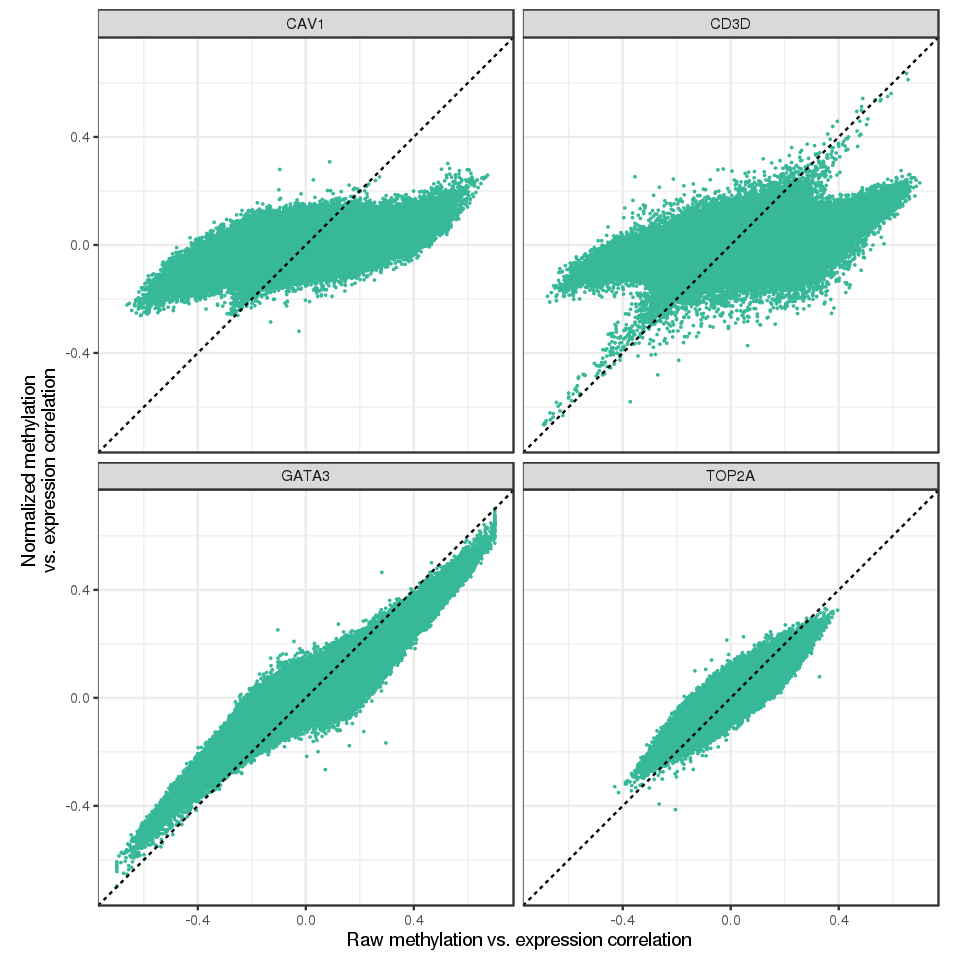

In [20]:
options(repr.plot.width = 8, repr.plot.height = 8)

lims <- c(-0.7, 0.7)

p_before_after <- before_after_df %>% 
    mutate(ER = "ER+") %>%     
    mutate(
            cor_raw = tgutil::clip_vals(cor_raw, lims[1], lims[2]),
            cor_norm = tgutil::clip_vals(cor_norm, lims[1], lims[2])
        ) %>% 
    ggplot(aes(x=cor_raw, y=cor_norm, color=ER)) + 
        geom_point(size=0.001) + 
        scale_color_manual(values=annot_colors$ER1) + 
        geom_abline(linetype = "dashed") + 
        xlab("Raw methylation vs. expression correlation") +
        ylab("Normalized methylation\nvs. expression correlation") +
        facet_wrap(.~gene, nrow=2) + 
        guides(color=FALSE) + 
        xlim(lims[1], lims[2]) +
        ylim(lims[1], lims[2]) +
        theme(aspect.ratio=1)

p_before_after + theme_bw() + theme(aspect.ratio=1)

See appendix 1 for more TME normalization diagnostics.

# Define epigenomic scores

Now that we have TME-normalized methylation profiles we can look at their correlation structure in order to identify the epigenomic scores. 
We will start by clustering the normalized methylation of ER+ samples:

In [21]:
ER_positive_mat_raw <- all_meth[, intersect(colnames(all_meth), tcga_ER_positive_samples)]

In [22]:
ER_positive_mat <- all_norm_meth %>% select(chrom:end, any_of(tcga_ER_positive_samples)) %>% intervs_to_mat()

Filter loci that have low methylation (average of under 0.1):

In [23]:
means <- rowMeans(all_meth, na.rm=TRUE)
means_ER_positive <- rowMeans(ER_positive_mat_raw, na.rm=TRUE)

In [24]:
meth_thresh <- 0.1

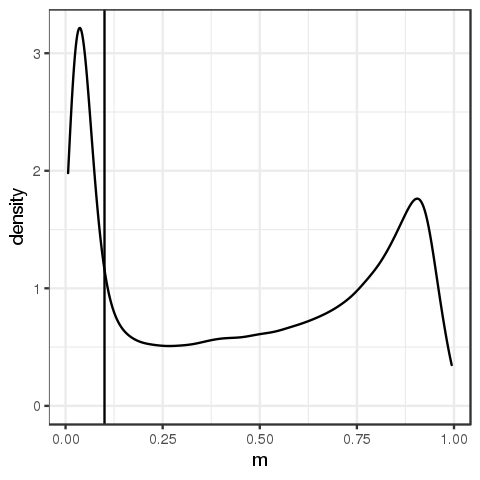

In [25]:
options(repr.plot.width = 4, repr.plot.height = 4)
tibble(m = means_ER_positive) %>% ggplot(aes(x=m))  + geom_density() + geom_vline(xintercept=meth_thresh) + theme_bw()

In [26]:
ER_positive_mat_s <- ER_positive_mat[means_ER_positive >= meth_thresh, ]
nrow(ER_positive_mat_s)

[1] 289121

We sample 20k loci and calculate a correlation matrix of their methylation values in ER+ samples:

In [27]:
set.seed(17)
ER_positive_mat_s <- ER_positive_mat_s[sample(1:nrow(ER_positive_mat_s), 2e4), ]

In [28]:
cm <- tgs_cor(t(ER_positive_mat_s), pairwise.complete.obs=TRUE) %fcache_rds% here("data/TCGA-BRCA/TCGA_BRCA_ER_positive_loci_cm_samp.rds")

We remove rows and columns without at least one correlation value above 0.25:

In [29]:
cm1 <- cm
diag(cm1) <- NA
cor_maxs <- matrixStats::rowMaxs(abs(cm1), na.rm=TRUE)
f <- cor_maxs >= 0.25
f <- f & rowSums(is.na(cm)) == 0
cm_f <- cm[f, f]

In [30]:
dim(cm_f)

[1] 19994 19994

We cluster the correlation matrix using `hclust`:

In [31]:
hc_meth <- as.dist(1-cm_f) %>% fastcluster::hclust(method = "ward.D2") %fcache_rds% here("data/TCGA-BRCA/TCGA_BRCA_ER_positive_loci_cm_hclust.rds")

Reorder the dendrogram according to average methylation:

In [32]:
hc_meth <- reorder(hc_meth, rowMeans(ER_positive_mat_raw[rownames(cm_f), ], na.rm=TRUE))

In [33]:
k <- 14

downscaling matrix

downscale k: 10

plotting



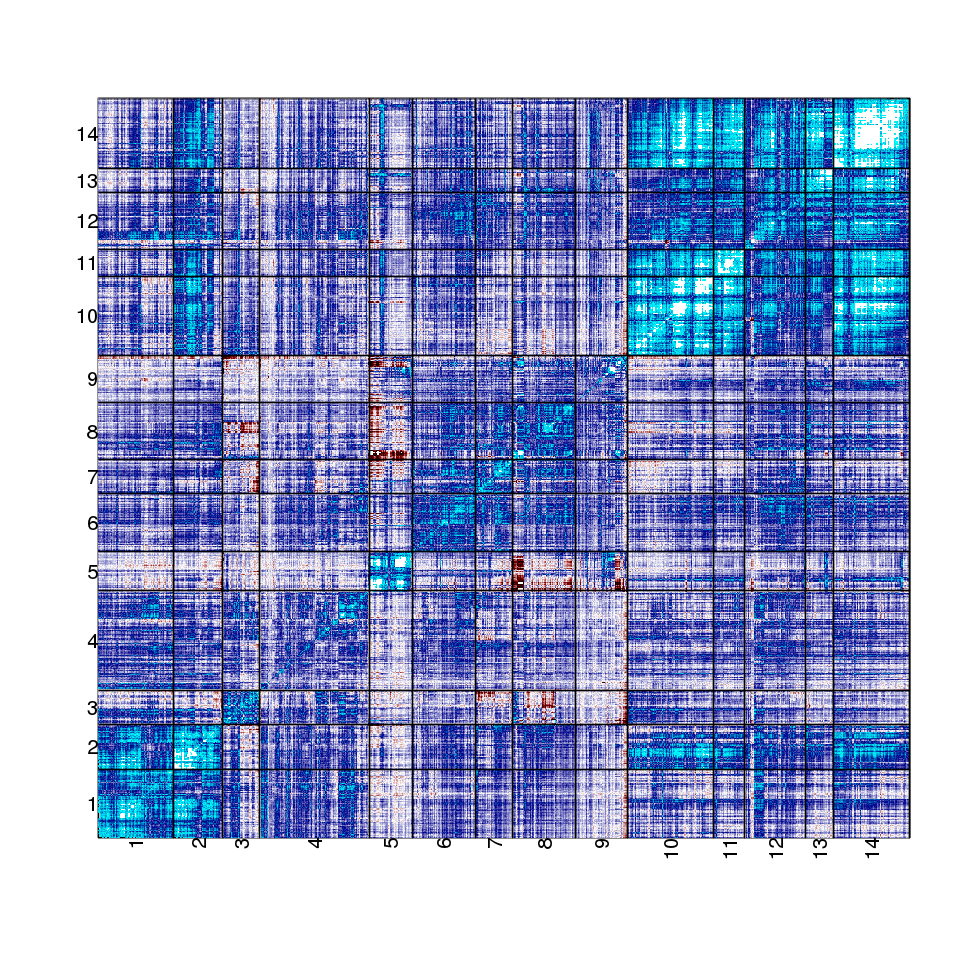

In [34]:
options(repr.plot.width = 8, repr.plot.height = 8)
plot_meth_mat_cm(
    cm_f, 
    k=k, 
    width = 1000, 
    height = 1000, 
    hc_meth=hc_meth, 
    downscale = TRUE, 
    zlim = c(-0.3, 0.3), 
    colors = c("black", "darkred", "white", "darkblue", "cyan"))

We can see that there is a large group of correlated loci at the top right (10-14), another group in the middle (6-8), and another one at the bottom left (1,2). In addition, we have another 2 small clusters (3 and 5).

The other clusters (4,9) look weak in their intra correalation. 

In [35]:
ct <- cutree_order(hc_meth, k=k)
ct_new <- case_when(
    ct %in% 10:14 ~ "clock", 
    ct %in% 6:9 ~ "ML", 
    ct %in% 1:2 ~ "MG",
    ct == 3 ~ "other1",     
    ct == 5 ~ "other2", 
    ct %in% c(4,9) ~ "no_cor")
names(ct_new) <- names(ct)

We will generate a score for each tumor based on the mean methylation of each group:

In [36]:
feats_mat <- tgs_matrix_tapply(all_norm_meth %>% intervs_to_mat() %>% .[names(ct_new), ] %>% t(), ct_new, mean, na.rm=TRUE) %>% t()

# We add the TME features for comparison
tme_df <- fread(here("data/TCGA-BRCA/TCGA_BRCA_TME_features.tsv")) %>% as_tibble()
feats_mat <- cbind(feats_mat, tme_df  %>% select(samp, caf, immune, caf.meth, immune.meth) %>% as.data.frame() %>% column_to_rownames("samp"))

In [37]:
feats_df <- feats_mat %>% 
    as.data.frame() %>% 
    rownames_to_column("samp") %>%     
    select(-other1, -other2, -no_cor) %>%
    left_join(tcga_samp_data %>% select(samp=samp_id, ER), by = "samp") %>%     
    select(samp, ER, everything()) %fcache_df% 
    here("data/TCGA-BRCA/TCGA_BRCA_epigenomic_features.tsv") %>% 
    as_tibble()

In [38]:
head(feats_df)

samp           ER  clock       MG            ML          caf        
1 TCGA_A1_A0SB_T ER+  0.01888207 -0.1252172243 -0.09579667 1.222652536
2 TCGA_A1_A0SE_T ER+ -0.01943815 -0.0229342503  0.01825924 0.585128289
3 TCGA_A1_A0SF_T ER+ -0.00529094  0.0003982838 -0.01191605 0.277531944
4 TCGA_A1_A0SG_T ER+ -0.08010315 -0.1000591290 -0.02661333 0.003446965
5 TCGA_A1_A0SI_T ER+ -0.05416858 -0.0369574188 -0.02084666 0.621719992
6 TCGA_A1_A0SJ_T ER+  0.06643913  0.0547740703  0.02349640 0.391526312
  immune       caf.meth  immune.meth
1 -1.932360349 0.4297221 0.6180962  
2  0.009182071 0.5917645 0.7026801  
3  0.793479727 0.5607568 0.6241409  
4  0.314856974 0.5603409 0.6285214  
5  0.757864580 0.5391400 0.6103056  
6  0.075408753 0.6324559 0.7086122

## Compare TCGA-BRCA epigenomic modules to METABRIC

Since TCGA-BRCA data is 450k based while METABRIC data is RRBS, it would be hard to compare the epigenomic modules directly. Fortunately, we can use the expression data as an anchor and compare the correlations of the methylation modules in each dataset with gene expression. If the genes that are correlated with each module are the same in both datasets it gives us high confidence that we are observing the same effect. 

Calculate correlation between the modules and every gene:

In [39]:
tcga_gene_cors <- plyr::ddply(feats_df, "ER", function(x) {
            samples <- reduce(list(tcga_samp_data$samp_id, colnames(tcga_expr), x$samp), intersect)
            feats_mat <- x %>%
                select(-ER) %>%
                as.data.frame() %>%
                column_to_rownames("samp") %>%
                as.matrix()
            cm <- tgs_cor(t(tcga_expr[, samples]), feats_mat[samples, ], pairwise.complete.obs = TRUE)
            cm <- cm %>%
                as.data.frame() %>%
                rownames_to_column("name") %>%
                as_tibble()
        return(cm %>% mutate(ER = x$ER[1]))
        })
head(tcga_gene_cors)

name  clock       MG           ML          caf         immune      
1 A1BG   0.04849510  0.003149984  0.24601114  0.04908175 -0.074749797
2 A1CF   0.10798897  0.061904818 -0.03467173 -0.01548953  0.110957541
3 A2BP1  0.01341289 -0.000587340  0.22526708  0.19762620  0.007679025
4 A2LD1 -0.04122864 -0.097998921  0.01634378  0.09301897  0.088271914
5 A2ML1 -0.13092742 -0.189658881 -0.33538301 -0.03703322  0.039981388
6 A2M    0.01943741 -0.128176602 -0.10856015  0.44829072  0.196500885
  caf.meth    immune.meth  ER 
1  0.08028370  0.114162819 ER-
2 -0.01249476 -0.045891226 ER-
3 -0.07261832 -0.009398886 ER-
4 -0.06744866 -0.052208571 ER-
5 -0.10419845 -0.186983947 ER-
6 -0.19331311 -0.152809835 ER-

In [40]:
metabric_gene_cors <- get_expression_features_cors() %>% mutate(clock = -clock, ML = -ML)

> Note that the METABRIC scores that involved loss of methylation in tumors were reversed (so that higher score => higher difference from the normal), so we reverse them back in order to compare with the TCGA-BRCA modules

In [41]:
df <- tcga_gene_cors %>% 
    rename(
        tcga.clock = clock, 
        tcga.MG = MG, 
        tcga.ML = ML, 
        tcga.caf = caf, 
        tcga.immune = immune, 
        tcga.caf.meth = caf.meth, 
        tcga.immune.meth = immune.meth) %>% 
    left_join(metabric_gene_cors, by = c("name", "ER")) %>% 
    mutate(ER = factor(ER, levels = c("ER+", "ER-", "normal")))

In [44]:
df %>% na.omit() %>% count(ER)

ER     n    
1 ER+    17125
2 ER-    17125
3 normal 16757

In [21]:
df_cross <- df %>% gather("feat1", "cor1", -ER, -name) %>% left_join(df %>% gather("feat2", "cor2", -ER, -name))  %>% filter(grepl("tcga", feat1), !grepl("tcga", feat2)) %>% na.omit() %>% filter(is.finite(cor1), is.finite(cor2)) %>% group_by(feat1, feat2, ER) %>% mutate(feat_cor = cor(cor1, cor2, use = "pairwise.complete.obs"))

Joining, by = c("name", "ER")



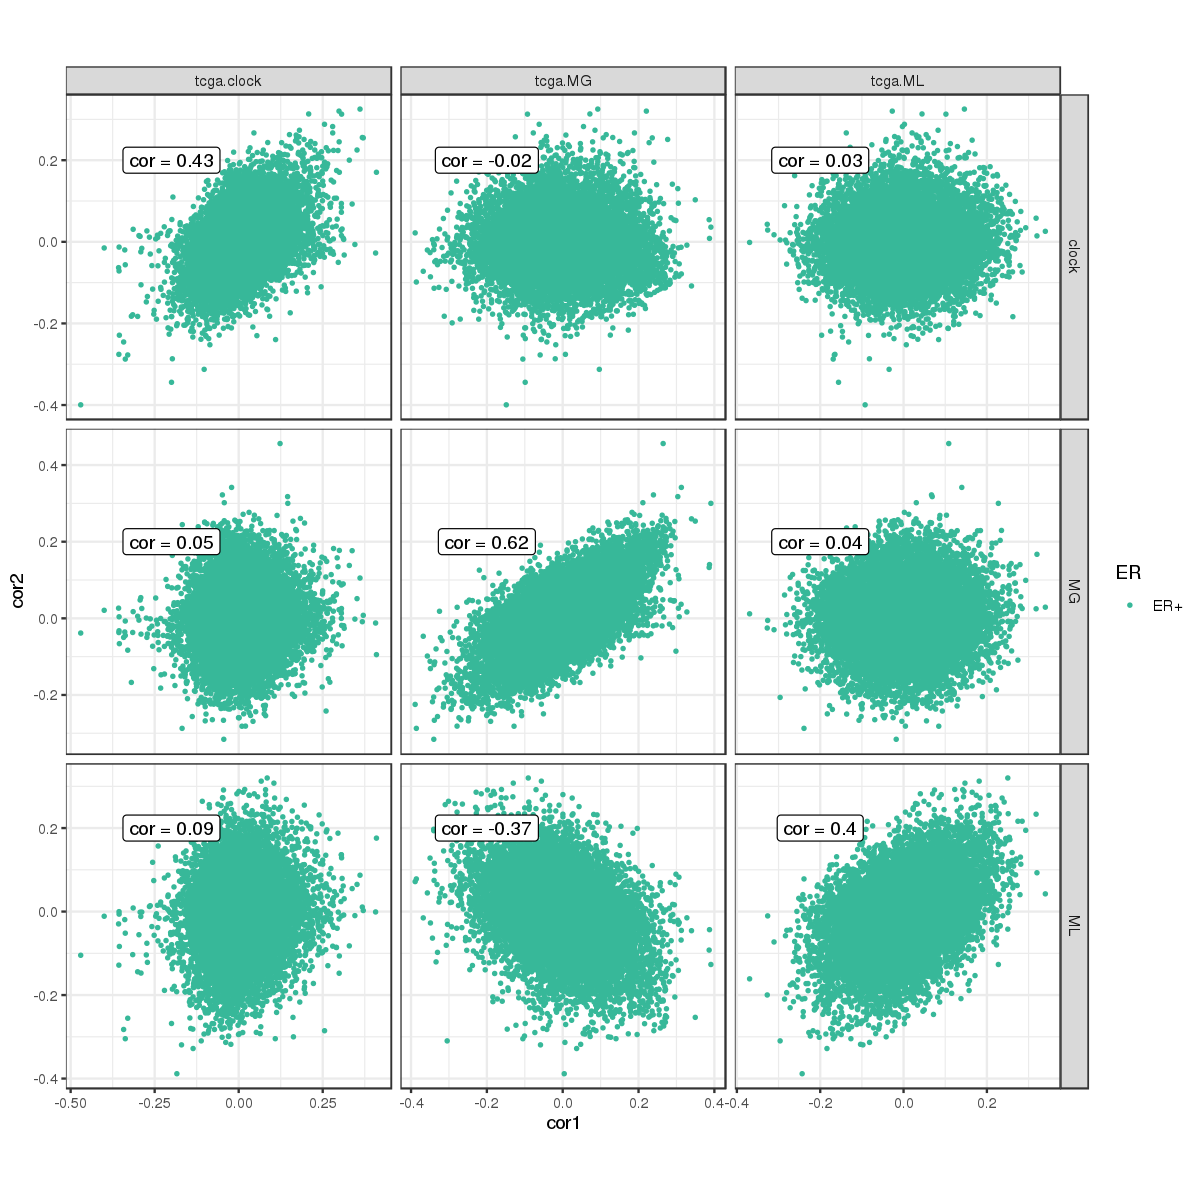

In [22]:
options(repr.plot.width=10, repr.plot.height=10)
df_cross1 <- df_cross %>% 
    filter(ER == "ER+") %>% 
    filter(!grepl("immune", feat1), !grepl("caf", feat1), !grepl("immune", feat2), !grepl("caf", feat2)) 
df_cross1 %>% 
    ggplot(aes(x=cor1, y=cor2, color=ER)) + geom_point(size=0.5) + theme_bw() + theme(aspect.ratio = 1) + facet_wrap(~ER) + scale_color_manual(values = annot_colors$ER1) + geom_label(data = df_cross1 %>% distinct(feat1, feat2, feat_cor, ER) %>% mutate(feat_cor = paste0("cor = ", round(feat_cor, digits=2))), inherit.aes = TRUE, aes(label = feat_cor), x=-0.2, y=0.2, color="black") + facet_grid(feat2 ~ feat1, scales="free") 

X axis has the correlations of gene expression with the modules we identified in the TCGA-BRCA dataset and Y axis has correlations of the same genes with the METABRIC modules. 

We can see indeed that there is a good correspondence between the modules we termed "clock", "MG" and "ML" in the TCGA dataset and the same modules in the METABRIC cohort. 

We will now plot the same correlations for ER- tumors:

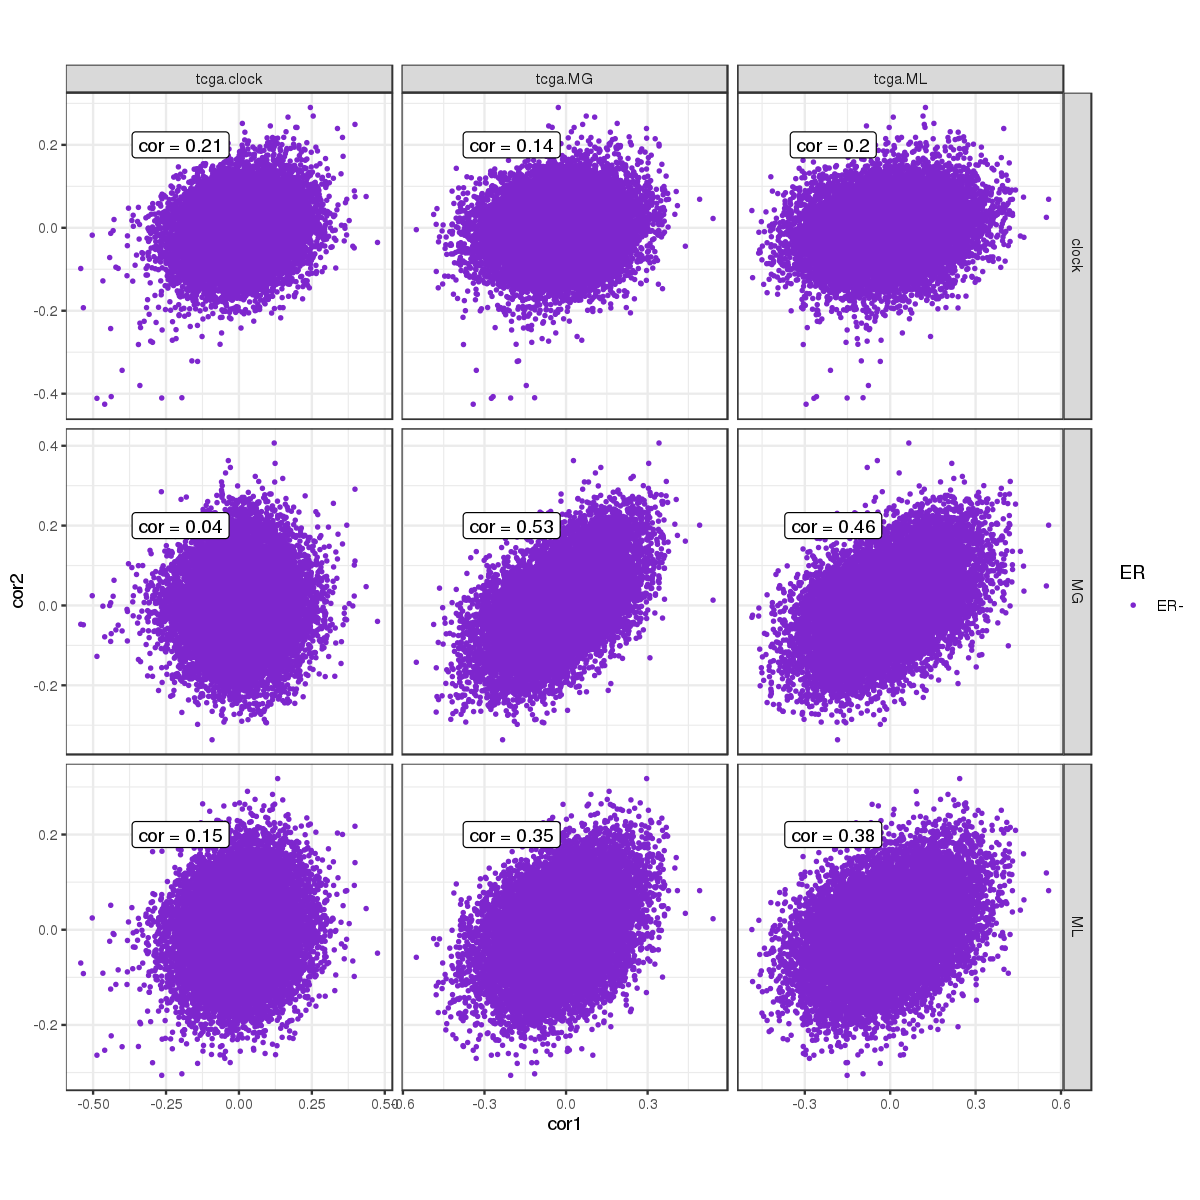

In [23]:
options(repr.plot.width=10, repr.plot.height=10)
df_cross1 <- df_cross %>% 
    filter(ER == "ER-") %>% 
    filter(!grepl("immune", feat1), !grepl("caf", feat1), !grepl("immune", feat2), !grepl("caf", feat2)) 
df_cross1 %>% 
    ggplot(aes(x=cor1, y=cor2, color=ER)) + geom_point(size=0.5) + theme_bw() + theme(aspect.ratio = 1) + facet_wrap(~ER) + scale_color_manual(values = annot_colors$ER1) + geom_label(data = df_cross1 %>% distinct(feat1, feat2, feat_cor, ER) %>% mutate(feat_cor = paste0("cor = ", round(feat_cor, digits=2))), inherit.aes = TRUE, aes(label = feat_cor), x=-0.2, y=0.2, color="black") + facet_grid(feat2 ~ feat1, scales="free") 

We can see that the correlation exists also in the ER- tumors, though to a less extent. Specifically, ML and MG are correlated also to each other (MG to ML and vice versa). This makes sense since the scores were derived using methylation data from ER+ tumors.

## Correlation between the features

We look at the correlations between the features in ER+/ER-/normal samples separately:

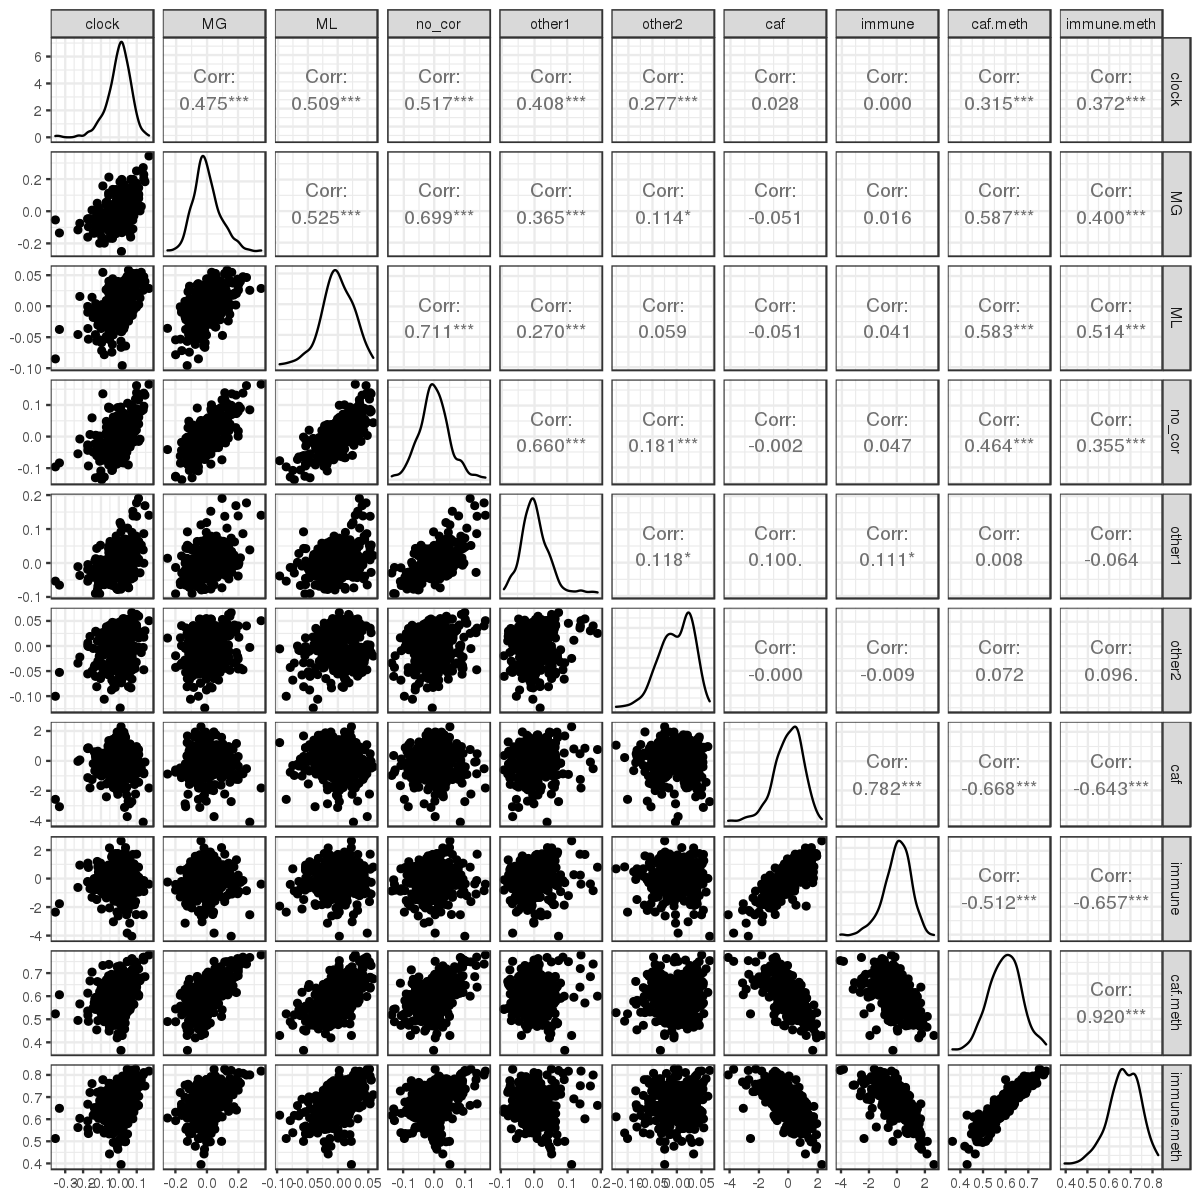

In [39]:
options(repr.plot.width = 10, repr.plot.height = 10)
GGally::ggpairs(feats_mat[intersect(rownames(feats_mat), tcga_ER_positive_samples), ] %>% as.data.frame(), progress = FALSE) + theme_bw()

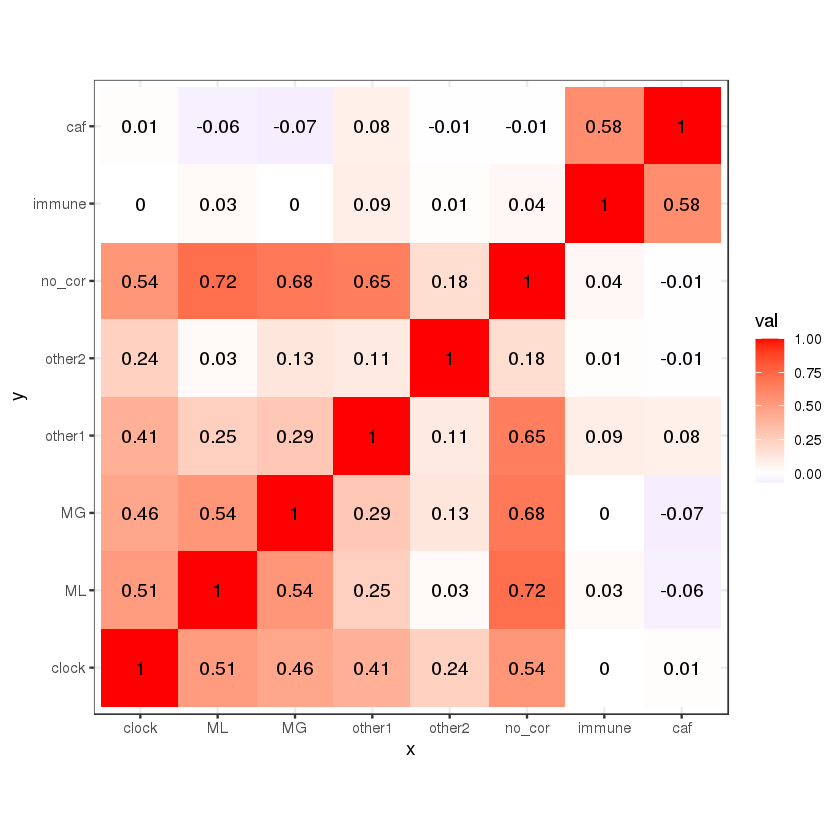

In [40]:
options(repr.plot.width = 7, repr.plot.height = 7)
feats_cm <- tgs_cor(as.matrix(feats_mat), pairwise.complete.obs=TRUE)
gather_matrix(feats_cm) %>% 
    mutate(val = round(val, digits=2)) %>% 
    mutate(x = factor(x, levels = c("clock", "ML", "MG", "other1", "other2", "no_cor", "immune", "caf"))) %>% 
    mutate(y = factor(y, levels = c("clock", "ML", "MG", "other1", "other2", "no_cor", "immune", "caf"))) %>% 
    filter(!is.na(x), !is.na(y)) %>% 
    ggplot(aes(x=x, y=y, fill=val, label=val)) + geom_tile() + geom_text()  + scale_fill_gradient2(low = "blue", high = "red") + theme_bw() + theme(aspect.ratio=1)

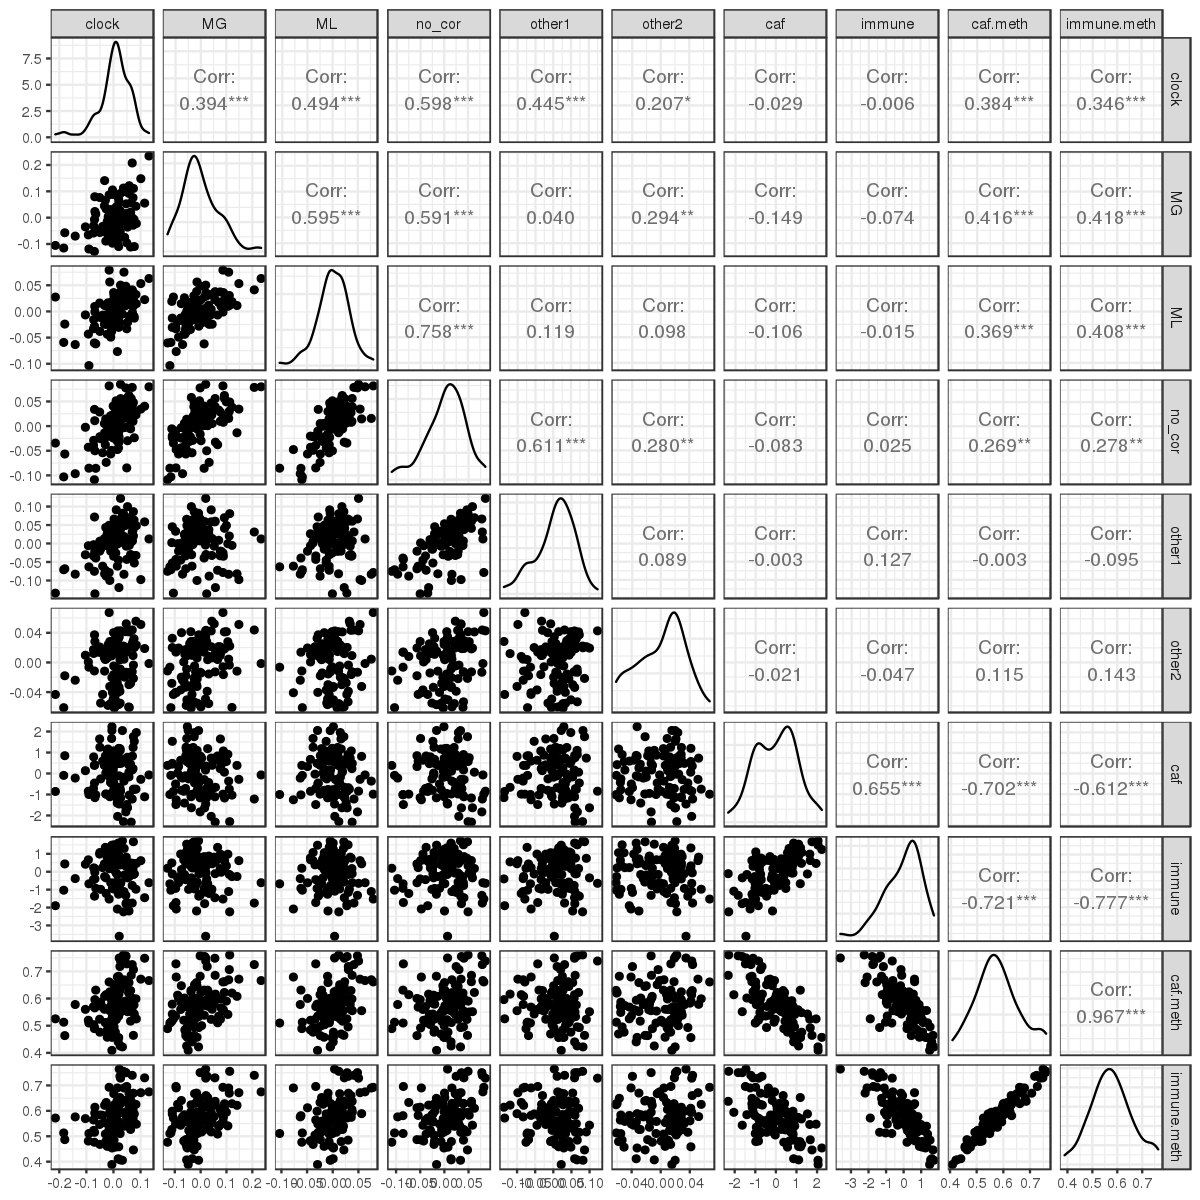

In [41]:
options(repr.plot.width = 10, repr.plot.height = 10)
GGally::ggpairs(feats_mat[intersect(rownames(feats_mat), tcga_ER_negative_samples), ] %>% as.data.frame(), progress = FALSE) + theme_bw()

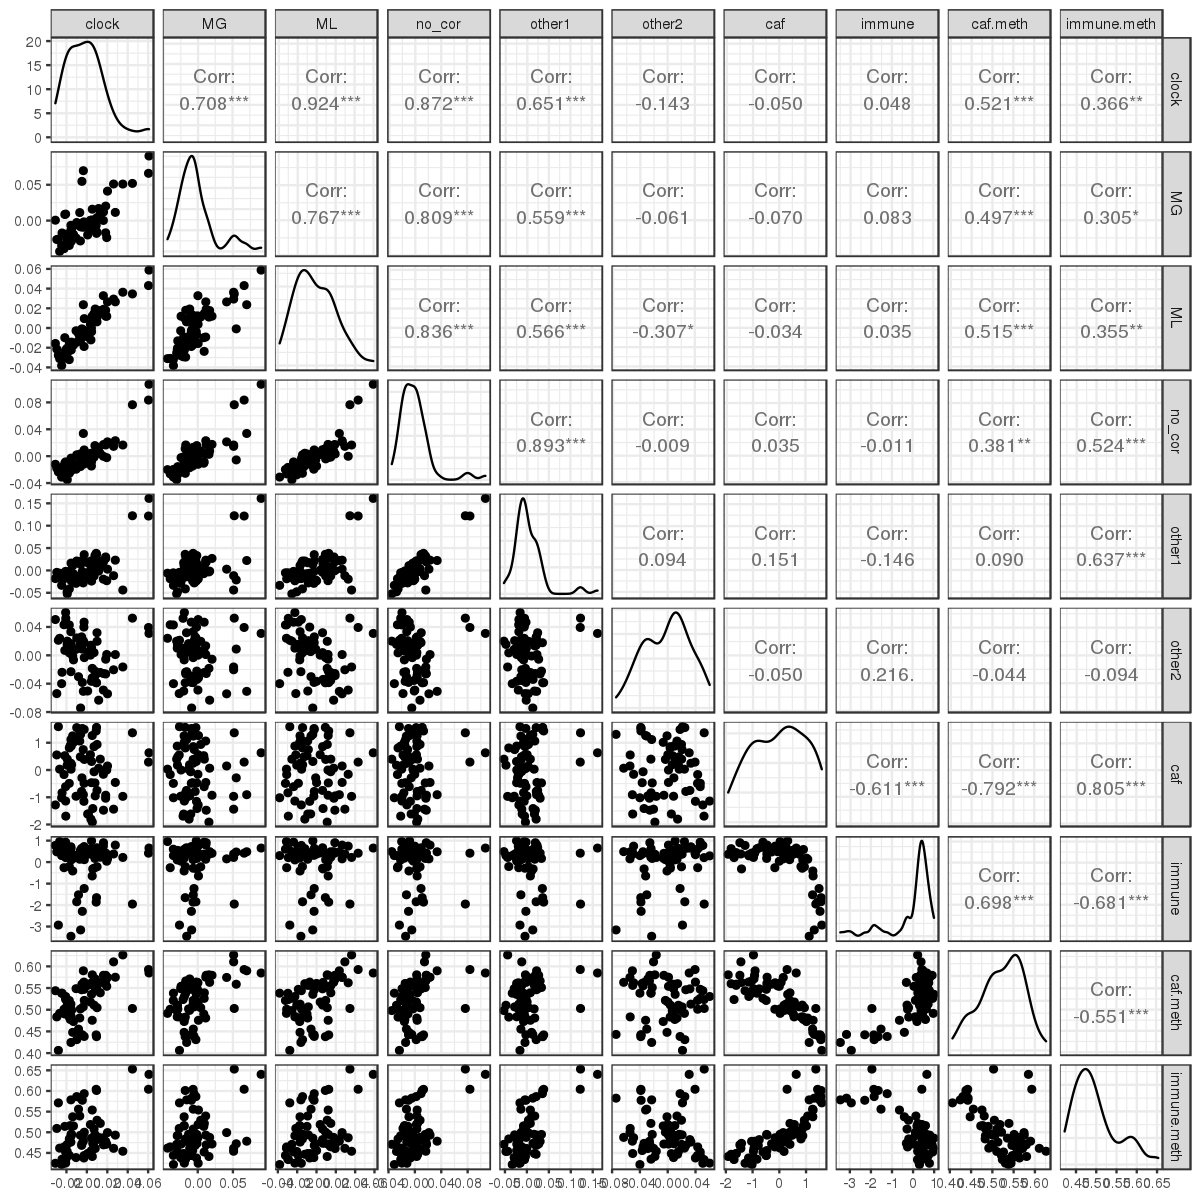

In [42]:
options(repr.plot.width = 10, repr.plot.height = 10)
GGally::ggpairs(feats_mat[intersect(rownames(feats_mat), tcga_normal_samples), ] %>% as.data.frame(), progress = FALSE) + theme_bw()

# Methylation regulation of gene expression _in cis_

We start by identifying genes that are strongly correlated to TME (immune and CAF) in the expression-methylation correlation clusters. Our TME normalization cleaned most of their correlations with methylation, but it is not perfect we don't want their _in cis_ effects to mask other more interesting expression-methylation correlations. 

In [4]:
TME_genes <- {
    ER_pos_TME_genes <- get_TME_genes(readr::read_rds(here("data/TCGA-BRCA/TCGA_BRCA_ER_positive_norm_meth.rds"))$em_cross_clust)
    ER_neg_TME_genes <- get_TME_genes(readr::read_rds(here("data/TCGA-BRCA/TCGA_BRCA_ER_negative_norm_meth.rds"))$em_cross_clust)
    normal_TME_genes <- get_TME_genes(readr::read_rds(here("data/TCGA-BRCA/TCGA_BRCA_normals_norm_meth.rds"))$em_cross_clust)

    unique(c(ER_pos_TME_genes, ER_neg_TME_genes, normal_TME_genes)) 
} %cache_rds% here("data/TCGA-BRCA/TCGA_BRCA_TME_genes.rds")

length(TME_genes)

[1] 2421

In [14]:
expr_mat_f <- tcga_expr[!(rownames(
tcga_expr) %in% TME_genes), ]
dim(expr_mat_f)

[1] 18080  1212

### Load normalized methylation and separate it to promoters and non-promoters

In [10]:
prom_meth <- get_tcga_brca_prom_meth_TME_norm() %>% mat_to_intervs()

In [30]:
non_prom_meth <- get_tcga_brca_genomic_meth(track = "TCGA.BRCA_450k_norm") %>% mat_to_intervs()

In [11]:
prom_intervs_f <- resolve_alt_promoters(prom_meth %>% select(chrom:end))

## Promoters

We use `methylayer` to identify promoters that are correlated _in cis_ to the expression of their gene: 

In [12]:
ER_positive_prom_mat_norm <- prom_meth %>% select(chrom:end, any_of(tcga_ER_positive_samples)) %>% intervs_to_mat()
ER_negative_prom_mat_norm <- prom_meth %>% select(chrom:end, any_of(tcga_ER_negative_samples)) %>% intervs_to_mat()
normal_prom_mat_norm <- prom_meth %>% select(chrom:end, any_of(tcga_normal_samples)) %>% intervs_to_mat()

dim(ER_positive_prom_mat_norm)
dim(ER_negative_prom_mat_norm)
dim(normal_prom_mat_norm)

[1] 32378   357

[1] 32378   111

[1] 32378    69

We remove rows with missing values (these are almost always loci that are not covered by 450k arrays).

In [13]:
f <- rowSums(is.na(ER_positive_prom_mat_norm)) == 0 & rowSums(is.na(ER_negative_prom_mat_norm)) == 0 & rowSums(is.na(normal_prom_mat_norm)) == 0
sum(f)

[1] 24670

In [15]:
tcga_prom_cands <- bind_rows(
    cis_em_promoters(ER_positive_prom_mat_norm[f, ], expr_mat_f, prom_intervs_f, min_samples=50) %>% mutate(ER = "ER+"), 
    cis_em_promoters(ER_negative_prom_mat_norm[f, ], expr_mat_f, prom_intervs_f, min_samples=50) %>% mutate(ER = "ER-"),
    cis_em_promoters(normal_prom_mat_norm[f, ], expr_mat_f, prom_intervs_f, min_samples=50) %>% mutate(ER = "normal") ) %cache_df% here("data/TCGA-BRCA/TCGA_BRCA_promoter_cis_cands.tsv") %>% as_tibble()  

In [17]:
df <- tcga_prom_cands %>% filter(r == 1)  %>% distinct(fdr, n_fdr, ER)

df_fdr <- tcga_prom_cands %>% 
    filter(fdr < 0.05) %>% 
    group_by(ER) %>% 
    filter(fdr == max(fdr)) %>% 
    distinct(fdr, n_fdr, ER)

df
df_fdr

glue("we identified {n_top_ER_pos} promoters in ER+ and {n_top_ER_neg} in ER- (FDR<0.01; {n_fdr_ER_pos} in ER+ and {n_fdr_ER_neg} in ER- if increasing FDR to <0.05)", 
     n_top_ER_pos = df$n_fdr[df$ER == "ER+"], 
     n_top_ER_neg = df$n_fdr[df$ER == "ER-"], 
     n_fdr_ER_pos = df_fdr$n_fdr[df_fdr$ER == "ER+"], 
     n_fdr_ER_neg = df_fdr$n_fdr[df_fdr$ER == "ER-"])

fdr         n_fdr ER    
1 0.001149425 870   ER+   
2 0.001862197 537   ER-   
3 0.038461538  26   normal

fdr        n_fdr ER    
1 0.04979643 3193  ER+   
2 0.04963235 2176  ER-   
3 0.03846154   26  normal

we identified 870 promoters in ER+ and 537 in ER- (FDR<0.01; 3193 in ER+ and 2176 in ER- if increasing FDR to <0.05)

### Compare to METABRIC _cis_ regulated genes

In [18]:
metabric_prom_cands <- fread(here("data/promoter_cis_cands.tsv")) %>% as_tibble()  

In [24]:
max_r <- 1
tcga_top_cands <- tcga_prom_cands %>% filter(r <= max_r)
metabric_top_cands <- metabric_prom_cands %>% filter(r <= max_r)

In [25]:
genes <- intersect(tcga_prom_cands$name, metabric_prom_cands$name)

In [26]:
tcga_top_genes <- tcga_top_cands %>% filter(name %in% genes) %>% pull(name) %>% unique()
metabric_top_genes <- metabric_top_cands %>% filter(name %in% genes) %>% pull(name) %>% unique()

In [29]:
scales::percent(sum(metabric_top_genes %in% tcga_top_genes) / length(metabric_top_genes))
scales::percent(sum(tcga_top_genes %in% metabric_top_genes) / length(tcga_top_genes))

[1] "50%"

[1] "39%"

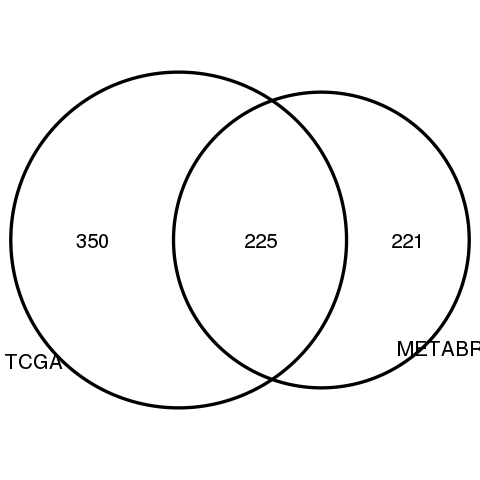

In [28]:
options(repr.plot.width = 4, repr.plot.height = 4)
grid.draw(list(`METABRIC` = metabric_top_genes, `TCGA` = tcga_top_genes) %>% VennDiagram::venn.diagram(filename=NULL))

We can see that 50% of the genes that were identified as candidates for cis regulation in the metabric cohort were also identified as such in TCGA, and 39% of the TCGA candidate genes were also identified in the METABRIC cohort. 

In [ ]:
phyper(length(intersect(metabric_top_genes, tcga_top_genes)), length(metabric_top_genes), length(genes) - length(metabric_top_genes), length(tcga_top_genes), lower.tail=FALSE)

## Non-promoters

We use `methylayer` to identify non promoter regions that are correlated _in cis_ to expression of _any_ gene within their vicinity. 

In [31]:
ER_positive_genomic_mat <- non_prom_meth %>% select(chrom:end, any_of(tcga_ER_positive_samples)) %>% intervs_to_mat()
ER_negative_genomic_mat <- non_prom_meth %>% select(chrom:end, any_of(tcga_ER_negative_samples)) %>% intervs_to_mat()
normal_genomic_mat <- non_prom_meth %>% select(chrom:end, any_of(tcga_normal_samples)) %>% intervs_to_mat()



dim(ER_positive_genomic_mat)
dim(ER_negative_genomic_mat)
dim(normal_genomic_mat)

[1] 176342    357

[1] 176342    111

[1] 176342     69

In [32]:
gene_tss <- get_gene_tss_coord()

Joining, by = "full_name"



In [26]:
genomic_cands_ER_pos <- cis_em_genomic(ER_positive_genomic_mat, expr_mat_f, gene_tss, min_samples=50, max_dist = 5e5, min_dist = 200) %>% mutate(ER = "ER+") %cache_df% here("data/TCGA-BRCA/TCGA_BRCA_genomic_cis_cands_ER_positive.tsv")

In [27]:
genomic_cands_ER_neg <- cis_em_genomic(ER_negative_genomic_mat, expr_mat_f, gene_tss, min_samples=50, max_dist = 5e5, min_dist = 200) %>% mutate(ER = "ER-") %cache_df% here("data/TCGA-BRCA/TCGA_BRCA_genomic_cis_cands_ER_negative.tsv")

In [28]:
genomic_cands_normals <- cis_em_genomic(normal_genomic_mat, expr_mat_f, gene_tss, min_samples=50, max_dist = 5e5, min_dist = 200) %>% mutate(ER = "normal") %cache_df% here("data/TCGA-BRCA/TCGA_BRCA_genomic_cis_cands_normal.tsv")

In [29]:
genomic_cis_cands <- bind_rows(
    genomic_cands_ER_pos,
    genomic_cands_ER_neg,
    genomic_cands_normals) %>% as_tibble()
head(genomic_cis_cands)
dim(genomic_cis_cands)

chrom start  end    type rank gene   cor        chrom_expr start_expr
1 chr1   10496  10587 obs  1    BEST3  -0.2179420 chr12       70093196 
2 chr1   10588  10639 obs  1    BEST3  -0.1361938 chr12       70093196 
3 chr1  134998 135215 obs  1    MAGEC2 -0.2520593 chrX       141293076 
4 chr1  546168 546310 obs  1    MAGEA8 -0.2346598 chrX       149009940 
5 chr1  565396 565791 obs  1    RAD51C -0.2161679 chr17       56769933 
6 chr1  567121 567237 obs  1    TIMM23 -0.2389887 chr10       51623386 
  end_expr  strand_expr dist n_obs n_shuff fdr      ER 
1  70093197 -1          NA   2861  89      0.031108 ER+
2  70093197 -1          NA   2861  89      0.031108 ER+
3 141293077 -1          NA   2861  89      0.031108 ER+
4 149009941  1          NA   2861  89      0.031108 ER+
5  56769934  1          NA   2861  89      0.031108 ER+
6  51623387 -1          NA   2861  89      0.031108 ER+

[1] 58128000       16

## Appendix 1: additional TME normalization diagnostics

#### Full expression-methylation correlation matrix before normalization

We can look at the cross-correlation matrix (of ER+) before normalization. Rows are genes and columns are methylation profiles. _methylayer_ identified the immune module as module number 5 and the CAFs module as module number 6.

In [ ]:
restart_env()
init_tcga_samp_data()
load_all_tcga_brca_data()
ER_positive_norm_meth <- readr::read_rds(here("data/TCGA-BRCA/TCGA_BRCA_ER_positive_norm_meth.rds"))
prom_meth <- get_tcga_brca_prom_meth_TME_norm() %>% mat_to_intervs()
ER_positive_prom_mat_norm <- prom_meth %>% select(chrom:end, any_of(tcga_ER_positive_samples)) %>% intervs_to_mat()

plotting em cross



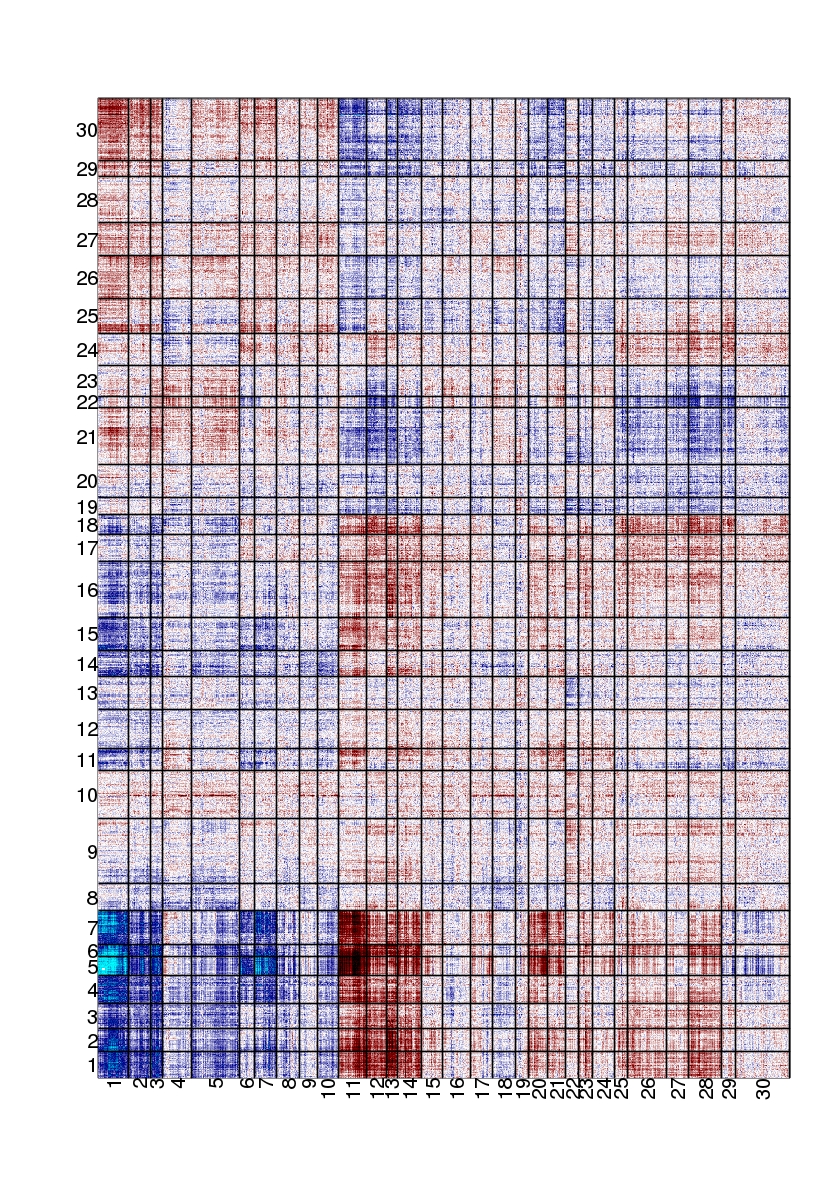

In [26]:
options(repr.plot.width = 7, repr.plot.height=10)
plot_em_cross_cor(ER_positive_norm_meth$em_cross_clust)